In [1]:
from fastcore.xtras import Path
zip_path = Path("clothing-dataset-full.zip")
zip_path.exists()

True

In [2]:
import zipfile
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("../data")

In [3]:
data_path = Path("../data")
data_path.ls()

(#3) [Path('../data/images.csv'),Path('../data/images_compressed'),Path('../data/images_original')]

In [4]:
from fastai.vision.all import *

In [5]:
(data_path/"images_compressed").ls()[:3]

(#3) [Path('../data/images_compressed/00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg'),Path('../data/images_compressed/00070a23-9faf-4682-8243-59f307880f4b.jpg'),Path('../data/images_compressed/000d31f6-44b5-4758-8d86-c4fcfb234392.jpg')]

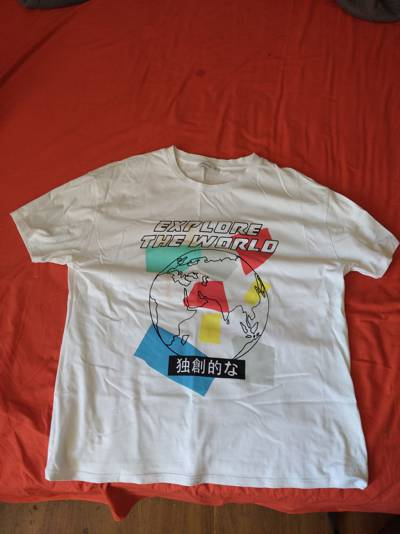

In [6]:
im_path = (data_path/"images_compressed").ls()[0]
im = Image.open(im_path)
im

In [7]:
bad_imgs = []
for im in (data_path/"images_compressed").ls():
    try:
        _ = Image.open(im)
    except:
        bad_imgs.append(im)
        im.unlink()

In [8]:
len(bad_imgs)

6

In [9]:
df = pd.read_csv(data_path/'images.csv')
df.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [10]:
len(df[~(df["label"] == "Not sure")])

5175

In [11]:
clean_df = df[~(df["label"] == "Not sure")]
clean_df.head()

,image,sender_id,label,kids
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
5,5d3a1404-697f-479f-9090-c1ecd0413d27,138,Shorts,False
6,b0c03127-9dfb-4573-8934-1958396937bf,138,Shirt,False


In [12]:
for img in bad_imgs:
    clean_df = clean_df[clean_df["image"] != img.stem]

In [13]:
len(clean_df)

5170

In [14]:
# our classes
clean_df["label"].unique(), len(clean_df["label"].unique())

(array(['T-Shirt', 'Shoes', 'Shorts', 'Shirt', 'Pants', 'Skirt', 'Other',
        'Top', 'Outwear', 'Dress', 'Body', 'Longsleeve', 'Undershirt',
        'Hat', 'Polo', 'Blouse', 'Hoodie', 'Skip', 'Blazer'], dtype=object),
 19)

In [15]:
blocks = (ImageBlock, CategoryBlock)
get_x = ColReader("image", pref=(data_path/"images_compressed"), suff=".jpg")
get_y = ColReader("label")

In [16]:
item_tfms = [Resize(224)]
batch_tfms = [*aug_transforms(), Normalize.from_stats(*imagenet_stats)]

In [17]:
dblock = DataBlock(
    blocks=blocks,
    get_x=get_x,
    get_y=get_y,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

In [18]:
dls = dblock.dataloaders(clean_df)

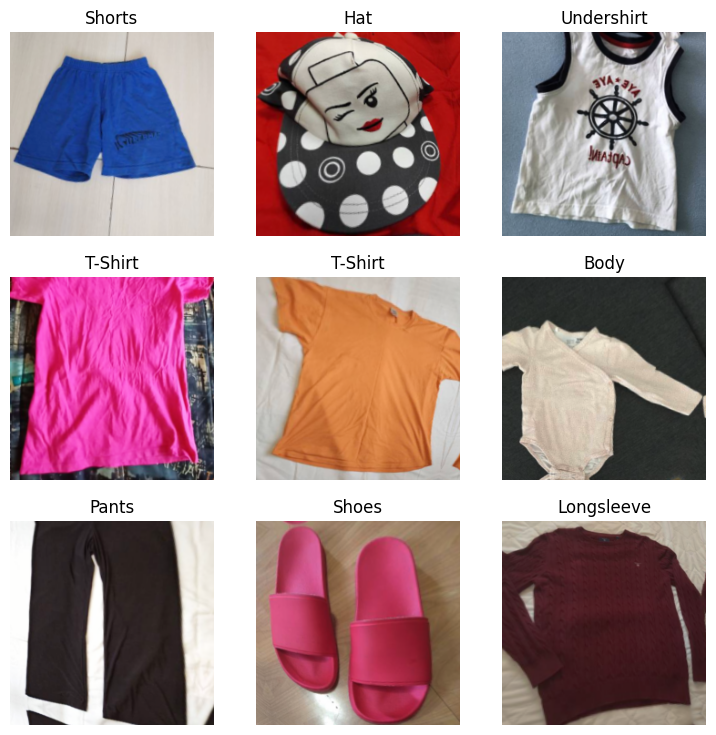

In [19]:
dls.show_batch()

In [20]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.381245,1.077851,0.697292,00:46


epoch,train_loss,valid_loss,accuracy,time
0,1.121601,0.712275,0.783366,00:56
1,0.849085,0.606904,0.822050,00:50
2,0.582313,0.532945,0.835590,00:50
3,0.413457,0.489053,0.852031,00:53
4,0.293283,0.472212,0.858801,00:47


In [21]:
interp = ClassificationInterpretation.from_learner(learn)

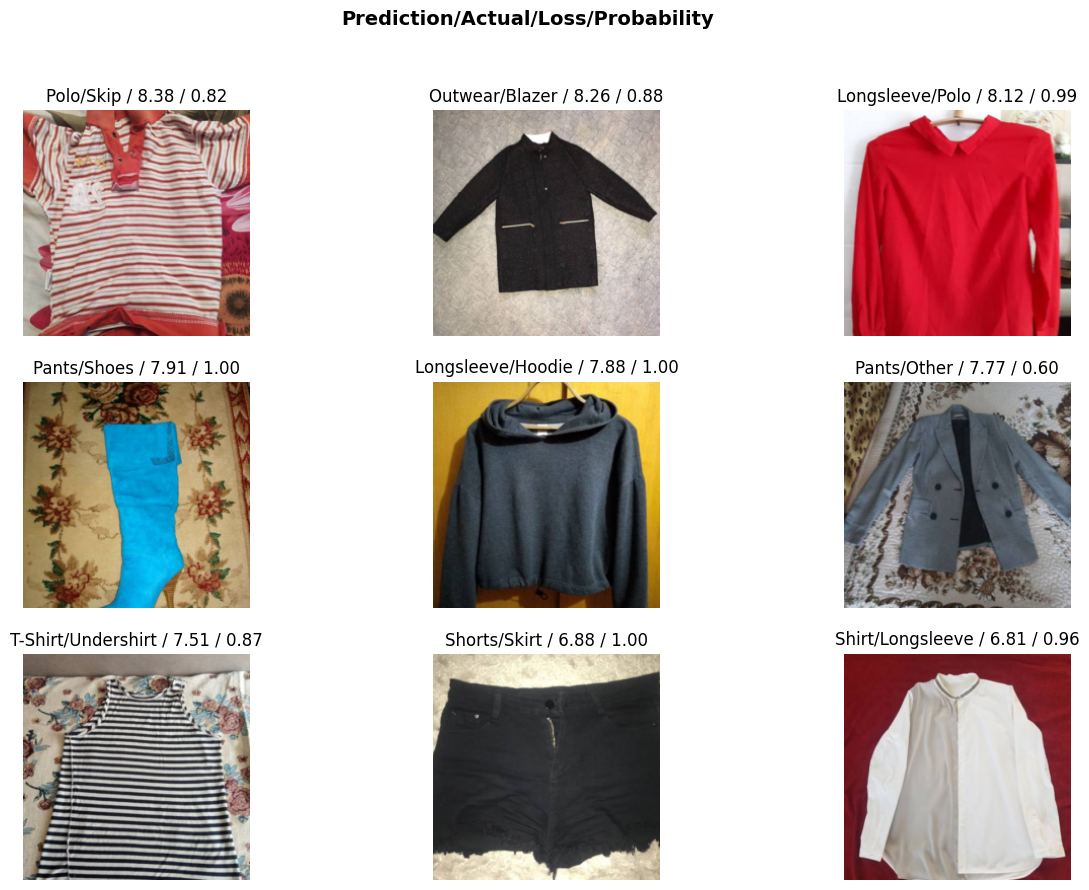

In [22]:
interp.plot_top_losses(9, figsize=(15,10))

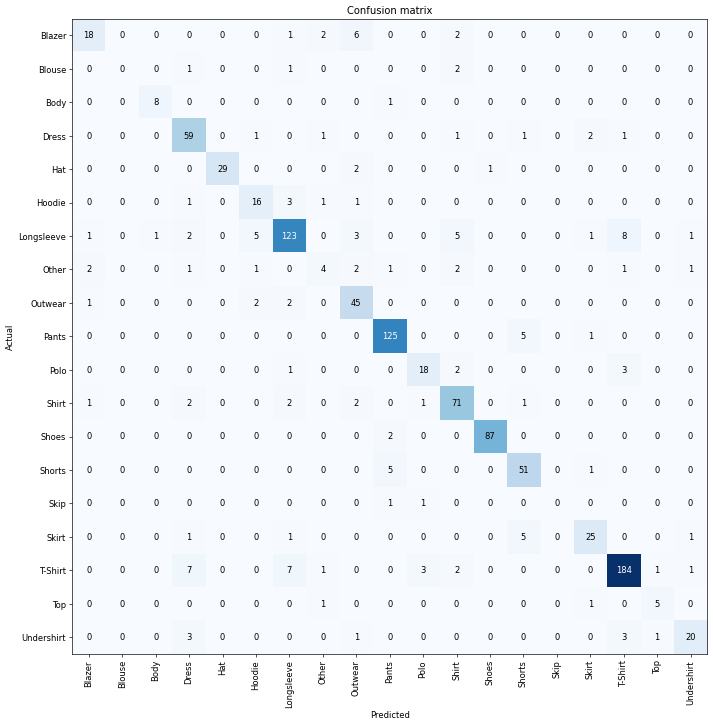

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)